###EECS 598 Coding Assignment 3
In this assignment, you are asked to solve the BipedalWalker-v3 problem using what you learned in this class.

In this environment a 2D bipedal walker has to learn a policy to walk without falling over. The total reward calculation is based on the total distance travelled by the agent. The episode ends when the walker touches the ground or it reaches the far right side of the environment. BipedalWalker-v3 is considered to be "solved" when the average reward is more than 300 over 100 consecutive trials.

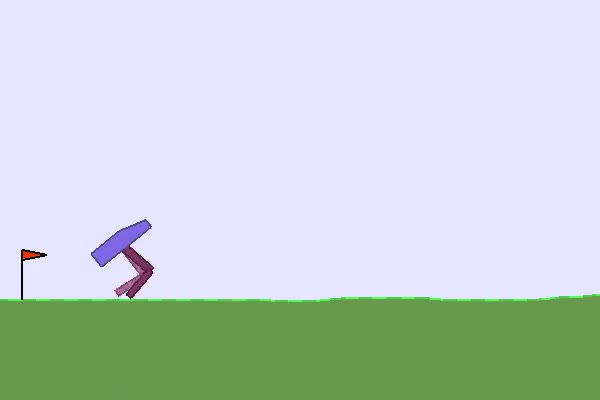

#### Environment

**Observation**

Num   | Observation                |  Min   |   Max  | Mean
------|----------------------------|--------|--------|------   
0     | hull_angle                 |  0     |  2*pi  |  0.5
1     | hull_angularVelocity       |  -inf  |  +inf  |  -
2     | vel_x                      |  -1    |  +1    |  -
3     |  vel_y                     |  -1    |  +1    |  -
4     | hip_joint_1_angle          |  -inf  |  +inf  |  -
5     | hip_joint_1_speed          |  -inf  |  +inf  |  -
6     | knee_joint_1_angle         |  -inf  |  +inf  |  -
7     | knee_joint_1_speed         |  -inf  |  +inf  |  -
8     | leg_1_ground_contact_flag  |  0     |  1     |  -
9     | hip_joint_2_angle          |  -inf  |  +inf  |  -
10    | hip_joint_2_speed          |  -inf  |  +inf  |  -
11    | knee_joint_2_angle         |  -inf  |  +inf  |  -
12    | knee_joint_2_speed         |  -inf  |  +inf  |  -
13    | leg_2_ground_contact_flag  |  0     |  1     |  -
14-23 | 10 lidar readings          |  -inf  |  +inf  |  -

**Actions (continuous)**

Num | Name                        | Min  | Max  
----|-----------------------------|------|------
0   | Hip_1 (Torque / Velocity)   |  -1  | +1
1   | Knee_1 (Torque / Velocity)  |  -1  | +1
2   | Hip_2 (Torque / Velocity)   |  -1  | +1
3   | Knee_2 (Torque / Velocity)  |  -1  | +1

**Reward**

Reward is given for moving forward, the walker can get 300+ points when reaching the far end. If the walker falls, it gets -100.


#### **Requirement** ####

1. Solve the problem by using any algorithms with a neural netowrk as an **actor** (input: states; output: action ).
2. Save the weights in to a file named ``actor.pth`` and upload it to gradescope.
3. The sturcture of the actor is fixed, do not make any changes. 

#### **Submission Instructions** ####

**Programming Language**

Please use Python 3.6x and use the following libraries only:
- Numpy
- pytorch
- Pandas
- Scikit-Learn
- gym

**Programing Instructions and grading rubric**

The algorithm [TD3](https://arxiv.org/abs/1802.09477) which can solve this problem successfully is shown below. I made some changes to the reward function to speed up the learning process. It usually takes 30~60 minutes to solve the problem with default GPU setting of Colab.

> The final grade for this homework is based on your **ranking**  on the leaderboard of gradescope after **solving** the problem.

Ranking(top) | Grade                        |
----|-----------------------------|
0%~10%   | 10   |  
10%~20%   | 9  |  
20%~30%   | 8  |  
others who solve this problem   | 7 |  


**Submitting format**

Please submit the file ``actor.pth`` to gradescope. Your code will be graded automatically. 


In [1]:
'''
Structure of Actor Neural Network.
'''
class Actor(nn.Module):
    def __init__(self, state_size, action_size, max_action=1, fc_units=256, fc1_units=256):
        super(Actor, self).__init__()

        self.max_action = max_action
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc1_units)
        self.fc3 = nn.Linear(fc1_units, action_size)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x)) * self.max_action


NameError: name 'nn' is not defined

In [3]:
'''
---------------------------------------------------------
Implementing of TD3
---------------------------------------------------------
'''

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
from collections import namedtuple, deque
import torch.optim as optim
import random
import matplotlib.pyplot as plt
%matplotlib inline 

import os
import time

In [4]:
#Construct Neural Networks

class Actor(nn.Module):
    def __init__(self, state_size, action_size, max_action, fc_units=256, fc1_units=256):
        super(Actor, self).__init__()

        self.max_action = max_action
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc1_units)
        self.fc3 = nn.Linear(fc1_units, action_size)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x)) * self.max_action

# Q1-Q2-Critic Neural Network

class Critic_Q(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=256):
        super(Critic_Q, self).__init__()

        # Q1 architecture
        self.l1 = nn.Linear(state_size + action_size, fc1_units)
        self.l2 = nn.Linear(fc1_units, fc2_units)
        self.l3 = nn.Linear(fc2_units, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_size + action_size, fc1_units)
        self.l5 = nn.Linear(fc1_units, fc2_units)
        self.l6 = nn.Linear(fc2_units, 1)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xa = torch.cat([state, action], 1)

        x1 = F.relu(self.l1(xa))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        x2 = F.relu(self.l4(xa))
        x2 = F.relu(self.l5(x2))
        x2 = self.l6(x2)
        return x1, x2

In [ ]:
class TD3:
    def __init__(
        self,name,env,
        load = False,
        gamma = 0.99, #discount factor
        lr_actor = 3e-4,
        lr_critic = 3e-4,
        batch_size = 100,
        buffer_capacity = 1000000,
        tau = 0.02,  #soft update parameter
        random_seed = 666,
        cuda = True,
        policy_noise=0.2, 
        std_noise = 0.1,
        noise_clip=0.5,
        policy_freq=2, #target network update period
    ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.env = env
        self.upper_bound = float(self.env.action_space.high[0]) #action space upper bound
        self.lower_bound = float(self.env.action_space.low[0])  #action space lower bound
        self.create_actor()
        self.create_critic()
        self.act_opt = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.crt_opt = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.set_weights()
        self.replay_memory_buffer = deque(maxlen = buffer_capacity)
        self.batch_size = batch_size
        self.tau = tau
        self.policy_freq = policy_freq
        self.gamma = gamma
        self.name = name
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.std_noise = std_noise   
        
    def create_actor(self):
        params = {
            'state_size':      self.env.observation_space.shape[0],
            'action_size':     self.env.action_space.shape[0],
            'max_action':      self.upper_bound
        }
        self.actor = Actor(**params).to(self.device)
        self.actor_target = Actor(**params).to(self.device)

    def create_critic(self):
        params = {
            'state_size':      self.env.observation_space.shape[0],
            'action_size':     self.env.action_space.shape[0]
        }
        self.critic = Critic_Q(**params).to(self.device)
        self.critic_target = Critic_Q(**params).to(self.device)

    def set_weights(self):
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())


    def add_to_replay_memory(self, state, action, reward, next_state, done):
      #add samples to replay memory
        self.replay_memory_buffer.append((state, action, reward, next_state, done))

    def get_random_sample_from_replay_mem(self):
      #random samples from replay memory
        random_sample = random.sample(self.replay_memory_buffer, self.batch_size)
        return random_sample

    def learn_and_update_weights_by_replay(self,training_iterations):
        """Update policy and value parameters using given batch of experience tuples.
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        """
        if len(self.replay_memory_buffer) < self.batch_size:
            return
        for it in range(training_iterations):
            mini_batch = self.get_random_sample_from_replay_mem()
            state_batch = torch.from_numpy(np.vstack([i[0] for i in mini_batch])).float().to(self.device)
            action_batch = torch.from_numpy(np.vstack([i[1] for i in mini_batch])).float().to(self.device)
            reward_batch = torch.from_numpy(np.vstack([i[2] for i in mini_batch])).float().to(self.device)
            next_state_batch = torch.from_numpy(np.vstack([i[3] for i in mini_batch])).float().to(self.device)
            done_list = torch.from_numpy(np.vstack([i[4] for i in mini_batch]).astype(np.uint8)).float().to(self.device)

            # Training and updating Actor & Critic networks.
            #Train Critic
            target_actions = self.actor_target(next_state_batch)
            offset_noises = torch.FloatTensor(action_batch.shape).data.normal_(0, self.policy_noise).to(self.device)

            #clip noise
            offset_noises = offset_noises.clamp(-self.noise_clip, self.noise_clip)
            target_actions = (target_actions + offset_noises).clamp(self.lower_bound, self.upper_bound)

            #Compute the target Q value
            Q_targets1, Q_targets2 = self.critic_target(next_state_batch, target_actions)
            Q_targets = torch.min(Q_targets1, Q_targets2)
            Q_targets = reward_batch + self.gamma * Q_targets * (1 - done_list)

            #Compute current Q estimates
            current_Q1, current_Q2 = self.critic(state_batch, action_batch)
            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, Q_targets.detach()) + F.mse_loss(current_Q2, Q_targets.detach())
            # Optimize the critic
            self.crt_opt.zero_grad()
            critic_loss.backward()
            self.crt_opt.step()

            #Train Actor
            # Delayed policy updates
            if it % self.policy_freq == 0:
                # Minimize the loss
                actions = self.actor(state_batch)
                actor_loss,_ = self.critic(state_batch, actions)
                actor_loss = - actor_loss.mean()

                # Optimize the actor               
                self.act_opt.zero_grad()
                actor_loss.backward()
                self.act_opt.step()

                #Soft update target models
                self.soft_update_target(self.critic, self.critic_target)
                self.soft_update_target(self.actor, self.actor_target)

    def soft_update_target(self,local_model,target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

    def policy(self,state):
        """select action based on ACTOR"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.actor.eval()
        with torch.no_grad():
            actions = self.actor(state).cpu().data.numpy()
        self.actor.train()
        return np.squeeze(actions)



In [ ]:
"""Install Environment"""
"""You may need to restart the kernel to use BipedalWalker."""
!pip install Box2D 

     |████████████████████████████████| 1.3MB 19.1MB/s 


In [ ]:
def eval_policy(agent, eval_env, seed, eval_episodes=10):
    eval_env = eval_env
    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = agent.policy(np.array(state))
            state, reward, done, _ = eval_env.step(action)
            avg_reward += reward
    avg_reward /= eval_episodes

    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print("---------------------------------------")
    return avg_reward

"""Training the agent"""
gym.logger.set_level(40)

def train(args):
    env = gym.make('BipedalWalker-v3')
    agent = TD3(args.rl_name, env, gamma=args.gamma, lr_actor=args.lr_actor, lr_critic=args.lr_critic,
                batch_size = args.batch_size, buffer_capacity=args.buffer_capacity, tau=args.tau, random_seed=args.seed,
                policy_freq=args.policy_freq)
    time_start = time.time()        # Init start time
    ep_reward_list = []
    avg_reward_list = []
    total_timesteps = 0


    for ep in range(args.total_episodes):
        state = env.reset()
        episodic_reward = 0
        timestep = 0

        for st in range(args.max_steps):
            # Select action randomly or according to policy
            if total_timesteps < args.start_timestep:
                action = env.action_space.sample()
            else:
                action = agent.policy(state)

            # Recieve state and reward from environment.
            next_state, reward, done, info = env.step(action)
            #change original reward from -100 to -5 and 5*reward for other values
            episodic_reward += reward
            if reward == -100:
                reward = -5
            else:
                reward = 5 * reward
            agent.add_to_replay_memory(state, action, reward, next_state, done)          
            # End this episode when `done` is True
            if done:
                break
            state = next_state
            timestep += 1     
            total_timesteps += 1

        ep_reward_list.append(episodic_reward)
        # Mean of last 100 episodes
        avg_reward = np.mean(ep_reward_list[-100:])
        avg_reward_list.append(avg_reward)

        if avg_reward > 290:
            test_reward = eval_policy(agent, env, seed=88, eval_episodes=10)
            if test_reward > 300:
                final_test_reward = eval_policy(agent, env, seed=88, eval_episodes=100)
                if final_test_reward > 300:
                    print("===========================")
                    print('Task Solved')
                    print("===========================")
                    #save weights
                    torch.save(agent.actor.state_dict(), 'actor.pth')
                    break            
        s = (int)(time.time() - time_start)
        agent.learn_and_update_weights_by_replay(timestep)
        print('Ep. {}, Timestep {},  Ep.Timesteps {}, Episode Reward: {:.2f}, Moving Avg.Reward: {:.2f}, Time: {:02}:{:02}:{:02}'
                .format(ep, total_timesteps, timestep,
                      episodic_reward, avg_reward, s//3600, s%3600//60, s%60)) 
    # Plotting graph
    # Episodes versus Avg. Rewards
    plt.plot(avg_reward_list)
    plt.xlabel("Episode")
    plt.ylabel("Avg. Epsiodic Reward")
    plt.show()
    env.close()


Ep. 0, Timestep 65,  Ep.Timesteps 65, Episode Reward: -116.07, Moving Avg.Reward: -116.07, Time: 00:00:00
Ep. 1, Timestep 1664,  Ep.Timesteps 1599, Episode Reward: -79.06, Moving Avg.Reward: -97.56, Time: 00:00:00
Ep. 2, Timestep 1725,  Ep.Timesteps 61, Episode Reward: -102.63, Moving Avg.Reward: -99.25, Time: 00:00:12
Ep. 3, Timestep 1815,  Ep.Timesteps 90, Episode Reward: -112.70, Moving Avg.Reward: -102.61, Time: 00:00:13
Ep. 4, Timestep 1877,  Ep.Timesteps 62, Episode Reward: -103.17, Moving Avg.Reward: -102.72, Time: 00:00:13
Ep. 5, Timestep 1966,  Ep.Timesteps 89, Episode Reward: -107.14, Moving Avg.Reward: -103.46, Time: 00:00:14
Ep. 6, Timestep 2041,  Ep.Timesteps 75, Episode Reward: -113.82, Moving Avg.Reward: -104.94, Time: 00:00:15
Ep. 7, Timestep 3640,  Ep.Timesteps 1599, Episode Reward: -85.74, Moving Avg.Reward: -102.54, Time: 00:00:16
Ep. 8, Timestep 3692,  Ep.Timesteps 52, Episode Reward: -106.41, Moving Avg.Reward: -102.97, Time: 00:00:28
Ep. 9, Timestep 3769,  Ep.Time

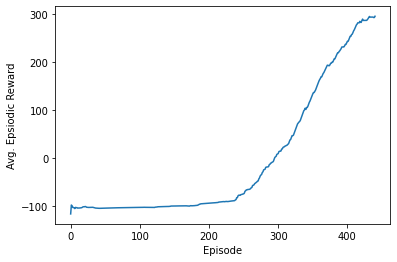

In [ ]:
import argparse
parser = argparse.ArgumentParser(description='td3')
parser.add_argument('--env-name', default="BipedalWalkerHardcore-v3")
parser.add_argument('--rl-name', default="td3")
parser.add_argument('--gamma', type=float, default=0.99,metavar='G',help='discounted factor')
parser.add_argument('--tau', type=float, default=0.01, metavar='G',help='target smoothing coefficient(τ)')
parser.add_argument('--lr-actor', type=float, default=0.0003, metavar='G',help='learning rate of actor')
parser.add_argument('--lr-critic', type=float, default=0.0003, metavar='G',help='learning rate of critic')
parser.add_argument('--seed', type=int, default=123456, metavar='N',help='random seed (default: 123456)')
parser.add_argument('--batch-size', type=int, default=100, metavar='N', help='batch size (default: 256)')
parser.add_argument('--buffer-capacity', type=int, default=1000000, metavar='N', help='buffer_capacity')
parser.add_argument('--max-steps', type=int, default=1600, metavar='N',help='maximum number of steps of each episode')
parser.add_argument('--total-episodes', type=int, default=3000, metavar='N',help='total training episodes')
parser.add_argument('--policy-freq', type=int, default=2, metavar='N',help='update frequency of target network ')
parser.add_argument('--start-timestep', type=int, default=10000, metavar='N',help='number of steps using random policy')
args = parser.parse_args("")

train(args)